<a href="https://colab.research.google.com/github/liupengzhouyi/DeepLearning/blob/main/%E8%9E%8D%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
pip3 install d2lzh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00
  Created wheel for d2lzh: filename=d2lzh-1.0.0-py3-none-any.whl size=10051 sha256=7a95131a83cc98b71dce80fce313c58cf2e9c17d2c65e471d9a4898b315192bb
  Stored in directory: /root/.cache/pip/wheels/24/f3/53/2ef7d38f67b79635bf43632cf79529950a0d48f76fffdbf0e3
Successfully built d2lzh


In [ ]:
%%shell
pip3 install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
%%shell
# python -m pip install numpy==1.24.3
pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.5.1 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.19.5 which is incompatible.
pandas 1.5.3 requires numpy>=1.20.3; python_version < "3.10", but you have numpy 1.19.5 which is incompatible.
orbax 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
ml-dtypes 0.1.0 requires nu

In [ ]:
import d2lzh as d2l
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time

In [ ]:
%%shell
pwd


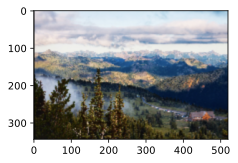

In [ ]:
d2l.set_figsize()
# response = requests.get(url)
# img = Image.open(BytesIO(response.content))
content_img = image.imread('/content/memos-2023_04_25 22_53_21.png')
d2l.plt.imshow(content_img.asnumpy());

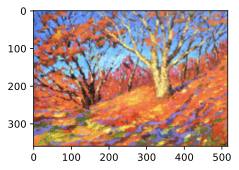

In [ ]:
style_img = image.imread('/content/memos-2023_04_25 22_53_31.png')
d2l.plt.imshow(style_img.asnumpy());

In [ ]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

In [ ]:
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [ ]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [ ]:
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [ ]:
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

In [ ]:
def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                  (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [ ]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [ ]:
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [ ]:
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [ ]:
# ctx, image_shape = d2l.try_gpu(), (225, 150)
# net.collect_params().reset_ctx(ctx)
# content_X, contents_Y = get_contents(image_shape, ctx)
# _, styles_Y = get_styles(image_shape, ctx)
# output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)

epoch  50, content loss 3.43, style loss 8.21, TV loss 2.37, 1.20 sec
epoch 100, content loss 2.55, style loss 4.81, TV loss 2.58, 1.20 sec
epoch 150, content loss 2.18, style loss 3.57, TV loss 2.67, 1.20 sec
epoch 200, content loss 1.97, style loss 2.96, TV loss 2.70, 1.21 sec
change lr to 1.0e-03
epoch 250, content loss 1.94, style loss 2.90, TV loss 2.70, 1.17 sec
epoch 300, content loss 1.93, style loss 2.86, TV loss 2.70, 1.57 sec
epoch 350, content loss 1.91, style loss 2.81, TV loss 2.70, 2.13 sec
epoch 400, content loss 1.89, style loss 2.77, TV loss 2.69, 1.57 sec
change lr to 1.0e-04
epoch 450, content loss 1.89, style loss 2.76, TV loss 2.69, 1.20 sec


In [ ]:
d2l.plt.imsave('/content/memos-neural-style-1.png', postprocess(output).asnumpy())

In [ ]:
image_shape = (450, 300)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 300, 100)
d2l.plt.imsave('/content/memos-neural-style-2.png', postprocess(output).asnumpy())

epoch  50, content loss 1.73, style loss 1.58, TV loss 1.44, 5.00 sec
epoch 100, content loss 1.20, style loss 1.20, TV loss 1.45, 6.42 sec
change lr to 1.0e-03
epoch 150, content loss 1.16, style loss 1.17, TV loss 1.45, 6.13 sec
epoch 200, content loss 1.13, style loss 1.15, TV loss 1.44, 4.98 sec
change lr to 1.0e-04
epoch 250, content loss 1.13, style loss 1.14, TV loss 1.44, 4.96 sec


In [ ]:
end_time = time.time()
print("程序执行了%f秒"%(end_time - start_time))

程序执行了1676.920352秒


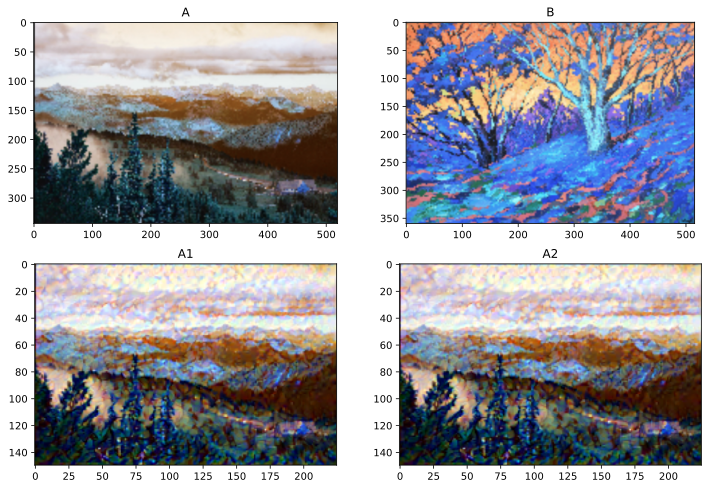

In [ ]:
import cv2
from matplotlib import pyplot as plt
img1 = cv2.imread('/content/memos-2023_04_25 22_53_21.png')
img2 = cv2.imread('/content/memos-2023_04_25 22_53_31.png')
img3 = cv2.imread('/content/memos-neural-style-1.png')
img4 = cv2.imread('/content/memos-neural-style-1.png')

# b, g, r = cv2.split(img)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('A')
plt.imshow(img1)

plt.subplot(2, 2, 2)
plt.title('B')
plt.imshow(img2)

plt.subplot(2, 2, 3)
plt.title('A1')
plt.imshow(img3)

plt.subplot(2, 2, 4)
plt.title('A2')
plt.imshow(img4)

plt.show()


In [ ]:
end_time = time.time()
print("程序执行了%f秒"%(end_time - start_time))

程序执行了2383.025535秒


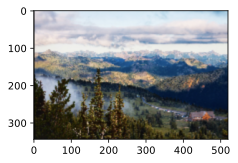

In [ ]:
content_img = image.imread('/content/memos-2023_04_25 22_53_21.png')
d2l.plt.imshow(content_img.asnumpy());

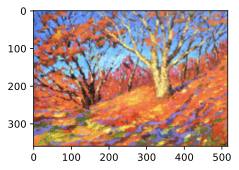

In [ ]:
style_img = image.imread('/content/memos-2023_04_25 22_53_31.png')
d2l.plt.imshow(style_img.asnumpy());

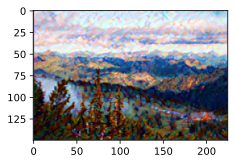

In [ ]:
style_img = image.imread('/content/memos-neural-style-1.png')
d2l.plt.imshow(style_img.asnumpy());

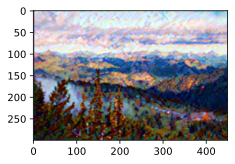

In [ ]:
style_img = image.imread('/content/memos-neural-style-2.png')
d2l.plt.imshow(style_img.asnumpy());